Processing Images:   0%|          | 0/40009 [00:00<?, ?it/s]

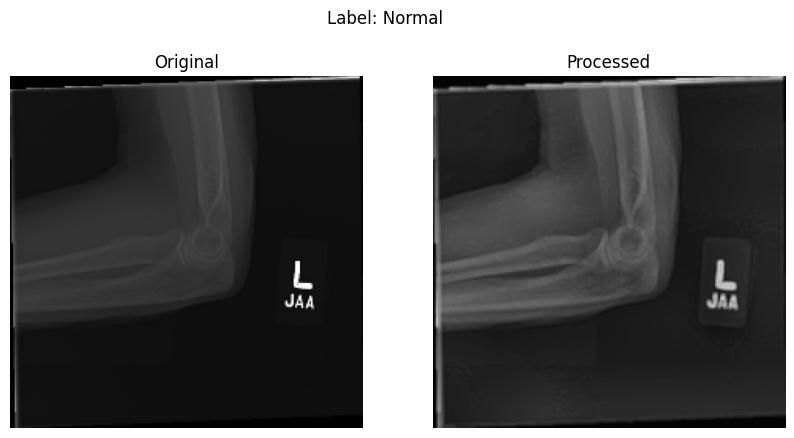

Processing Images:   0%|          | 1/40009 [00:00<3:29:30,  3.18it/s]

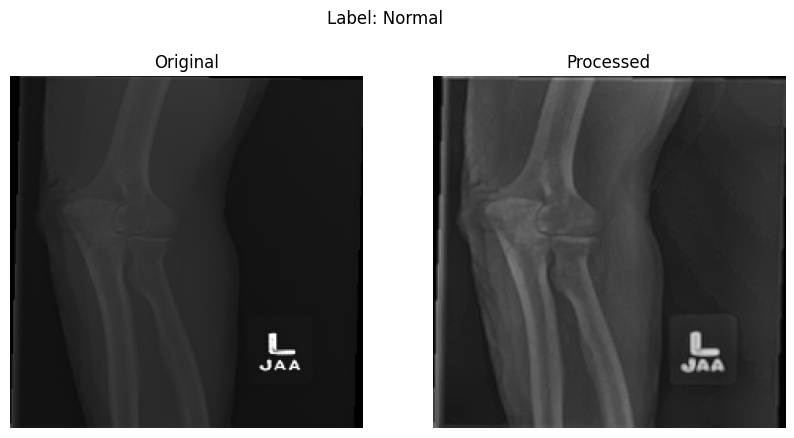

Processing Images:   0%|          | 2/40009 [00:00<2:12:23,  5.04it/s]

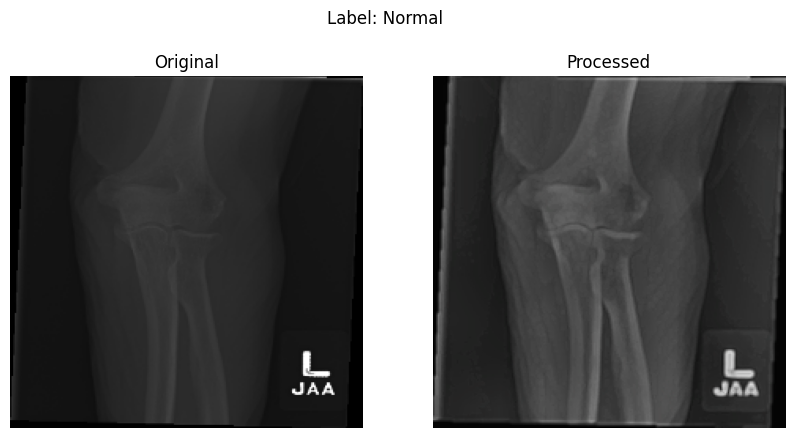

Processing Images:  83%|████████▎ | 33092/40009 [13:30<02:59, 38.61it/s]


Error processing D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study1_negative\._image1.png: Could not read image at D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study1_negative\._image1.png

Error processing D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study2_negative\._image1.png: Could not read image at D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study2_negative\._image1.png

Error processing D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study2_negative\._image2.png: Could not read image at D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study2_negative\._image2.png

Error processing D:/collage project/fracture detection comp vision/MURA-v1.1\train\XR_WRIST\patient07840\study2_negative\._image3.png: Could not read image at D:/collag

Processing Images: 100%|██████████| 40009/40009 [15:28<00:00, 43.09it/s]



✅ Preprocessing complete!
Processed images saved to: data/processed
New metadata saved to: data/processed\processed_metadata.csv


In [21]:
"""
X-ray Image Preprocessing Pipeline
----------------------------------
Loads metadata, preprocesses images for VGG models, and saves processed data and updated metadata.
"""

# ---- Import Required Libraries ----
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
from skimage import exposure

# ---- Embedded Configuration ----
CONFIG_YAML = """
data:
  metadata_path: "data/processed/metadata.csv"    
  raw_data_root: "D:/collage project/fracture detection comp vision/MURA-v1.1"        
  processed_dir: "data/processed"        
  target_size: [224,224]        
  visualize_samples: true                
"""

# ---- Load Configuration ----
def load_config(config_path=None):
    """
    Load preprocessing configuration from embedded YAML or file.
    
    Args:
        config_path (str, optional): Path to external YAML file. If None, uses embedded config.
    
    Returns:
        dict: Configuration settings.
    """
    if config_path:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
    else:
        config = yaml.safe_load(CONFIG_YAML)
    return config['data']

# [Rest of your original code remains exactly the same...]
def preprocess_xray(img):
    """
    Apply a series of image processing techniques to enhance X-ray images
    for better feature extraction by CNN models like VGG.
    """
    # 1. Gamma Correction
    img = exposure.adjust_gamma(img, gamma=0.7)
    
    # 2. Noise Reduction
    img = cv2.GaussianBlur(img, (3, 3), 1)
    
    # 3. CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # 4. Unsharp Masking
    blurred = cv2.GaussianBlur(img, (5, 5), 2.0)
    img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    
    # 5. Edge Enhancement
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_map = np.sqrt(sobelx**2 + sobely**2)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX)
    edge_map = cv2.cvtColor(edge_map.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(img, 0.7, edge_map, 0.3, 0)
    
    return img.astype(np.float32) / 255.0

def process_dataset():
    """Process all images listed in the metadata CSV"""
    config = load_config()
    metadata = pd.read_csv(config['metadata_path'])
    os.makedirs(config['processed_dir'], exist_ok=True)
    new_metadata = []

    for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing Images"):
        try:
            img = cv2.imread(row['path'])
            if img is None:
                raise ValueError(f"Could not read image at {row['path']}")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, tuple(config['target_size']))
            processed_img = preprocess_xray(img)

            rel_path = os.path.relpath(row['path'], config['raw_data_root'])
            new_path = os.path.join(config['processed_dir'], os.path.splitext(rel_path)[0] + '.npy')
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
            np.save(new_path, processed_img)

            new_metadata.append({
                'path': new_path,
                'label': row['label'],
                'original_path': row['path']
            })

            if config['visualize_samples'] and idx < 3:
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1,2,2)
                plt.imshow(processed_img)
                plt.title("Processed")
                plt.axis('off')

                plt.suptitle(f"Label: {'Fracture' if row['label'] else 'Normal'}")
                plt.show()

        except Exception as e:
            print(f"\nError processing {row['path']}: {str(e)}")
            continue

    new_metadata_path = os.path.join(config['processed_dir'], 'processed_metadata.csv')
    pd.DataFrame(new_metadata).to_csv(new_metadata_path, index=False)

    print("\n✅ Preprocessing complete!")
    print(f"Processed images saved to: {config['processed_dir']}")
    print(f"New metadata saved to: {new_metadata_path}")

if __name__ == "__main__":
    process_dataset()